# Comparison of Different Classification Methods
## Topic: How many Customers Stay

### Table of Content:
1. [Data Gathering](#first_part)
2. [Data Exploration](#second_part)
3. [Set up PyCaret](#third_part)
4. [Model Building](#fourth_part)
    1. [Gradient Boosting Classifier](#fourth_1_part)
    2. [Random Forest Classifier](#fourth_2_part)
    3. [CatBoost Classifier](#fourth_3_part)
5. [Evaluation](#fifth_part)

In [1]:
# Import packages
import pandas as pd
import numpy as np
from pycaret.classification import *
from pycaret.utils import check_metric

## 1. Data Gathering <a name="first_part"></a>

In [2]:
dataset = pd.read_csv("train.csv")
dataset.head()

RowNumber  CustomerId        Surname  CreditScore Geography  Gender  Age  \
0          0    15682273          Burns          683    France  Female   38   
1          1    15694321             Su          619    France  Female   28   
2          2    15807194  Iweobiegbulam          718     Spain    Male   34   
3          3    15643966        Goforth          616   Germany    Male   45   
4          4    15697686        Stewart          787    France  Female   40   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       5  127616.56              1          1               0   
1       3       0.00              2          1               0   
2       5  113922.44              2          1               0   
3       3  143129.41              2          0               1   
4       6       0.00              2          1               1   

   EstimatedSalary  Exited  
0        123846.07       0  
1         53394.12       0  
2         30772.22       0  
3         64327.26       0  
4         84151.98       0

In [3]:
# Withheld part of the data for validation

data = dataset.sample(frac=0.95, random_state=123)
data_unseen = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (7125, 14)
Unseen Data For Predictions: (375, 14)


## 2. Data Exploration <a name="second_part"></a>

In [4]:
print(f'Missing values: \n{data.isnull().sum()}')

Missing values: 
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


## 3. Set up PyCaret <a name="third_part"></a>

In [5]:
# Classify each column to different types of feature
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
ignore_features = ['RowNumber', 'CustomerId', 'Surname']

In [6]:
# Set up environment in PyCaret
exit_clf = setup(data = data, target='Exited', train_size=0.8, session_id=123, 
                categorical_features=categorical_features, 
                numeric_features=numeric_features, ignore_features=ignore_features) 
# remove_outliers = True

## 4. Model Building <a name="fourth_part"></a>

In [7]:
# Compare all models
compare_models(fold = 5)

### 4.1 Gradient Boosting Classifier <a name="fourth_1_part"></a>

In [8]:
# Create baseline gbc model
gbc = create_model('gbc', fold=5)
print(gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [9]:
# parameters for Gradient Boosting Classifier

gbc_params = {'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
              'n_estimators' : [2, 4, 8, 16, 32, 64, 128, 200, 256, 500],
              'max_depth': [2, 3, 5, 8, 10, 15, 25, 30],
              'min_samples_split':[2, 4, 6, 8, 10, 20, 40, 60, 100],
              'min_samples_leaf':[1, 3, 5, 7, 9],
              'max_features': ['auto', 'sqrt', 'log2']
             }

In [10]:
# Tune the baseline gbc model
tuned_gbc = tune_model(gbc, fold=5, custom_grid = gbc_params,  optimize = 'F1')#, search_algorithm = 'grid')
tuned_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=8,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=9, min_samples_split=40,
                           min_weight_fraction_leaf=0.0, n_estimators=64,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

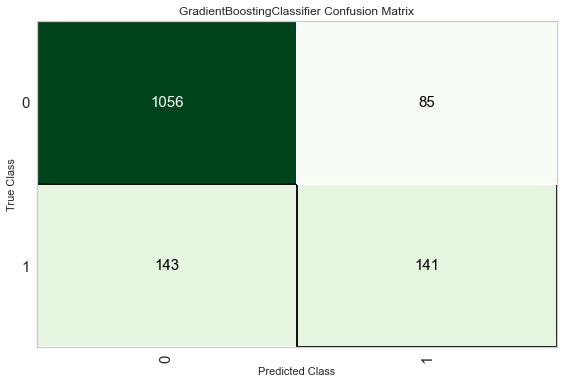

In [11]:
plot_model(tuned_gbc, plot='confusion_matrix')

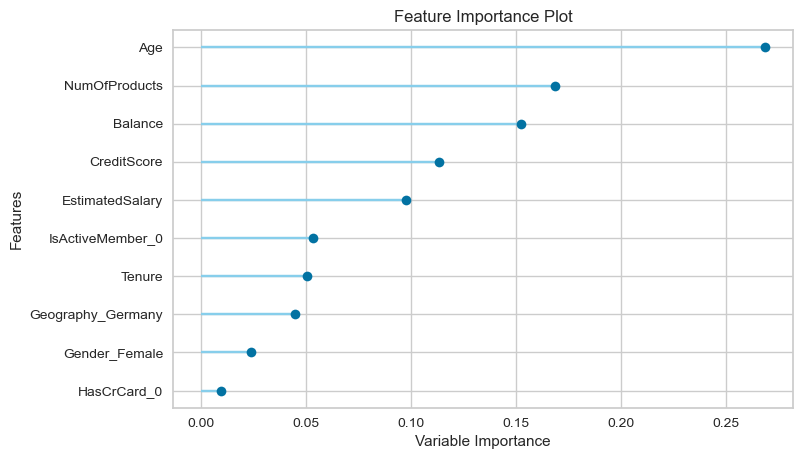

In [12]:
plot_model(tuned_gbc, plot='feature')

In [13]:
# Predict with the tuned model
final_gbc = finalize_model(tuned_gbc)
predict_model(final_gbc)

CreditScore   Age  Tenure        Balance  NumOfProducts  \
0           458.0  36.0     5.0       0.000000            2.0   
1           716.0  27.0     1.0  122552.343750            2.0   
2           619.0  28.0     3.0       0.000000            2.0   
3           740.0  56.0     4.0   99097.328125            1.0   
4           624.0  40.0     3.0  149961.984375            2.0   
...           ...   ...     ...            ...            ...   
1420        606.0  37.0     8.0  154712.578125            2.0   
1421        743.0  34.0     1.0  131736.875000            1.0   
1422        675.0  32.0    10.0       0.000000            2.0   
1423        637.0  28.0     3.0  123675.687500            1.0   
1424        599.0  35.0     6.0  137102.656250            1.0   

      EstimatedSalary  Geography_France  Geography_Germany  Geography_Spain  \
0        79723.781250               0.0                0.0              1.0   
1        67611.359375               0.0                1.0              0.0   
2        53394.121094               1.0                0.0              0.0   
3        85016.640625               0.0                0.0              1.0   
4       104610.859375               0.0                1.0              0.0   
...               ...               ...                ...              ...   
1420     89099.179688               0.0                0.0              1.0   
1421    108543.210938               0.0                1.0              0.0   
1422    191545.656250               0.0                0.0              1.0   
1423    166458.406250               0.0                1.0              0.0   
1424     76870.812500               0.0                0.0              1.0   

      Gender_Female  HasCrCard_0  IsActiveMember_0 Exited  Label   Score  
0               0.0          0.0               1.0      0      0  0.9995  
1               0.0          0.0               1.0      0      0  0.9746  
2               1.0          0.0               1.0      0      0  0.9509  
3               1.0          0.0               0.0      1      1  0.5789  
4               1.0          0.0               1.0      0      0  0.9656  
...             ...          ...               ...    ...    ...     ...  
1420            0.0          0.0               1.0      0      0  0.8539  
1421            1.0          0.0               0.0      0      0  0.9594  
1422            0.0          0.0               1.0      0      0  0.9995  
1423            0.0          0.0               0.0      0      0  0.9746  
1424            0.0          1.0               1.0      0      0  0.9538  

[1425 rows x 15 columns]

In [14]:
# Save the tuned model as final model (gbc)
save_model(final_gbc,'models/Final Gbc Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Geography',
                                                             'Gender',
                                                             'HasCrCard',
                                                             'IsActiveMember'],
                                       display_types=True,
                                       features_todrop=['RowNumber',
                                                        'CustomerId',
                                                        'Surname'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['CreditScore', 'Age',
                                                           'Tenure', 'Balance',
                                                           'NumOfProducts',
                         

In [15]:
# Predict on unseen data
gbc_predictions = predict_model(final_gbc, data=data_unseen)
gbc_predictions.head()

RowNumber  CustomerId Surname  CreditScore Geography  Gender  Age  Tenure  \
0         17    15703167   Rouse          628    France  Female   45       8   
1         39    15654238     Jen          673    France  Female   40       5   
2         96    15651103     Sal          762     Spain  Female   69       9   
3        111    15778515      Wu          748    France    Male   40       3   
4        194    15688963  Ingram          731    France  Female   52      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2          1               0        193903.06   
1  137494.28              1          1               0         81753.92   
2  183744.98              1          1               1        196993.69   
3   95297.11              1          0               0        171515.84   
4       0.00              1          1               1         24998.75   

   Exited  Label   Score  
0       0      0  0.6068  
1       0      0  0.8395  
2       0      0  0.9963  
3       0      0  0.5821  
4       1      1  0.8497

### 4.2 Random Forest Classifier <a name="fourth_2_part"></a>

In [16]:
rf = create_model('rf', fold=5)
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [17]:
# parameters for Random Forest Classifier

rf_params = { 'n_estimators' : [2, 4, 8, 16, 32, 64, 128, 200, 256, 500],
              'max_depth': [2, 3, 5, 8, 10, 15, 25],
              'min_samples_split': [2, 4, 6, 8, 10, 20, 40, 60],
              'min_samples_leaf': [1, 3, 5, 7, 9],
              'max_features': ['auto', 'sqrt', 'log2'],
              'bootstrap': [True, False],
             }


In [18]:
# Tune the baseline rf model
tuned_rf = tune_model(rf, fold=5, custom_grid = rf_params,  optimize = 'F1')#, search_algorithm = 'grid')
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

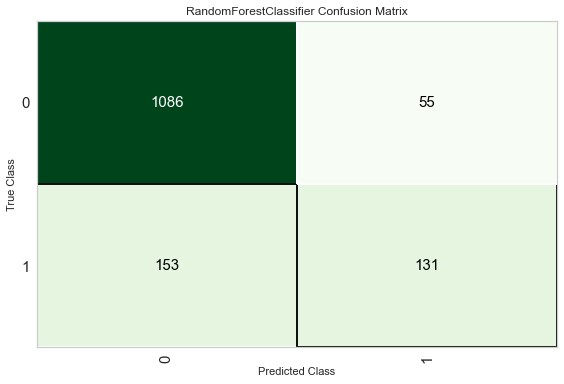

In [19]:
plot_model(tuned_rf, plot='confusion_matrix')

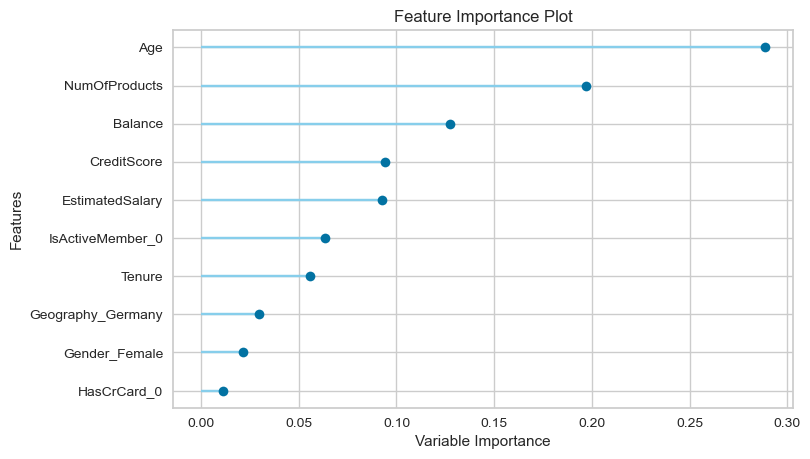

In [20]:
plot_model(tuned_rf, plot='feature')

In [21]:
# Predict with the tuned model
final_rf = finalize_model(tuned_rf)
predict_model(final_rf)

CreditScore   Age  Tenure        Balance  NumOfProducts  \
0           458.0  36.0     5.0       0.000000            2.0   
1           716.0  27.0     1.0  122552.343750            2.0   
2           619.0  28.0     3.0       0.000000            2.0   
3           740.0  56.0     4.0   99097.328125            1.0   
4           624.0  40.0     3.0  149961.984375            2.0   
...           ...   ...     ...            ...            ...   
1420        606.0  37.0     8.0  154712.578125            2.0   
1421        743.0  34.0     1.0  131736.875000            1.0   
1422        675.0  32.0    10.0       0.000000            2.0   
1423        637.0  28.0     3.0  123675.687500            1.0   
1424        599.0  35.0     6.0  137102.656250            1.0   

      EstimatedSalary  Geography_France  Geography_Germany  Geography_Spain  \
0        79723.781250               0.0                0.0              1.0   
1        67611.359375               0.0                1.0              0.0   
2        53394.121094               1.0                0.0              0.0   
3        85016.640625               0.0                0.0              1.0   
4       104610.859375               0.0                1.0              0.0   
...               ...               ...                ...              ...   
1420     89099.179688               0.0                0.0              1.0   
1421    108543.210938               0.0                1.0              0.0   
1422    191545.656250               0.0                0.0              1.0   
1423    166458.406250               0.0                1.0              0.0   
1424     76870.812500               0.0                0.0              1.0   

      Gender_Female  HasCrCard_0  IsActiveMember_0 Exited  Label   Score  
0               0.0          0.0               1.0      0      0  0.9614  
1               0.0          0.0               1.0      0      0  0.9615  
2               1.0          0.0               1.0      0      0  0.9286  
3               1.0          0.0               0.0      1      0  0.5682  
4               1.0          0.0               1.0      0      0  0.9373  
...             ...          ...               ...    ...    ...     ...  
1420            0.0          0.0               1.0      0      0  0.8512  
1421            1.0          0.0               0.0      0      0  0.9386  
1422            0.0          0.0               1.0      0      0  0.9706  
1423            0.0          0.0               0.0      0      0  0.9409  
1424            0.0          1.0               1.0      0      0  0.8604  

[1425 rows x 15 columns]

In [22]:
# Save the tuned model as final model (rf)
save_model(final_rf,'models/Final Rf Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Geography',
                                                             'Gender',
                                                             'HasCrCard',
                                                             'IsActiveMember'],
                                       display_types=True,
                                       features_todrop=['RowNumber',
                                                        'CustomerId',
                                                        'Surname'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['CreditScore', 'Age',
                                                           'Tenure', 'Balance',
                                                           'NumOfProducts',
                         

In [23]:
# Predict on unseen data
rf_predictions = predict_model(final_rf, data=data_unseen)
rf_predictions.head()

RowNumber  CustomerId Surname  CreditScore Geography  Gender  Age  Tenure  \
0         17    15703167   Rouse          628    France  Female   45       8   
1         39    15654238     Jen          673    France  Female   40       5   
2         96    15651103     Sal          762     Spain  Female   69       9   
3        111    15778515      Wu          748    France    Male   40       3   
4        194    15688963  Ingram          731    France  Female   52      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2          1               0        193903.06   
1  137494.28              1          1               0         81753.92   
2  183744.98              1          1               1        196993.69   
3   95297.11              1          0               0        171515.84   
4       0.00              1          1               1         24998.75   

   Exited  Label   Score  
0       0      0  0.7887  
1       0      0  0.6902  
2       0      0  0.7555  
3       0      0  0.6826  
4       1      0  0.5304

### 4.3 CatBoost Classifier <a name="fourth_3_part"></a>

In [24]:
catboost = create_model('catboost', fold=5)
print(catboost)

In [25]:
# parameters for CatBoost Classifier

catboost_params = {'depth': [4, 5, 6, 7, 8, 9, 10, 15, 25],
                   'learning_rate': [0.01, 0.02, 0.03, 0.04],
                   'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                  } 

In [26]:
# Tune the baseline catboost model
tuned_catboost = tune_model(catboost, fold=5, custom_grid = catboost_params,  optimize = 'F1')#, search_algorithm = 'grid')
tuned_catboost

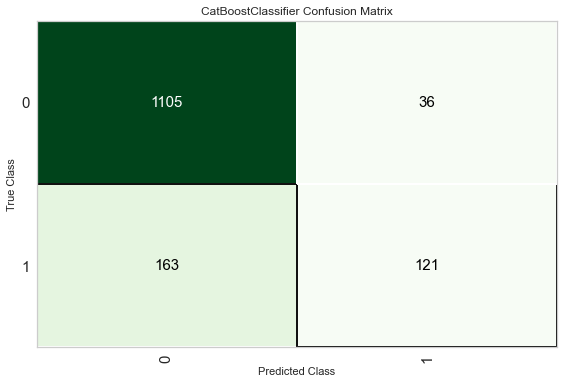

In [27]:
plot_model(tuned_catboost, plot='confusion_matrix')

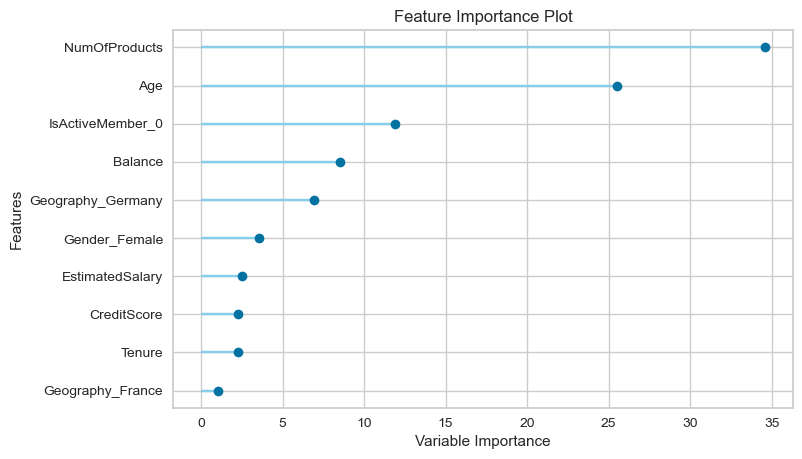

In [28]:
plot_model(tuned_catboost, plot='feature')

In [29]:
plot_model(tuned_catboost, plot='parameter') 

Parameters
nan_mode                                            Min
eval_metric                                     Logloss
iterations                                           80
sampling_frequency                              PerTree
leaf_estimation_method                           Newton
grow_policy                               SymmetricTree
penalties_coefficient                                 1
boosting_type                                     Plain
model_shrink_mode                              Constant
feature_border_type                        GreedyLogSum
bayesian_matrix_reg                 0.10000000149011612
l2_leaf_reg                                           3
random_strength                                       1
rsm                                                   1
boost_from_average                                False
model_size_reg                                      0.5
pool_metainfo_options                      {'tags': {}}
subsample                             0.800000011920929
use_best_model                                    False
class_names                                      [0, 1]
random_seed                                         123
depth                                                 9
posterior_sampling                                False
border_count                                        254
classes_count                                         0
auto_class_weights                                 None
sparse_features_conflict_fraction                     0
leaf_estimation_backtracking             AnyImprovement
best_model_min_trees                                  1
model_shrink_rate                                     0
min_data_in_leaf                                      1
loss_function                                   Logloss
learning_rate                      0.029999999329447743
score_function                                   Cosine
task_type                                           CPU
leaf_estimation_iterations                            1
bootstrap_type                                      MVS
max_leaves                                          512

In [30]:
# Predict with the tuned model
final_catboost = finalize_model(tuned_catboost)
predict_model(final_catboost)

CreditScore   Age  Tenure        Balance  NumOfProducts  \
0           458.0  36.0     5.0       0.000000            2.0   
1           716.0  27.0     1.0  122552.343750            2.0   
2           619.0  28.0     3.0       0.000000            2.0   
3           740.0  56.0     4.0   99097.328125            1.0   
4           624.0  40.0     3.0  149961.984375            2.0   
...           ...   ...     ...            ...            ...   
1420        606.0  37.0     8.0  154712.578125            2.0   
1421        743.0  34.0     1.0  131736.875000            1.0   
1422        675.0  32.0    10.0       0.000000            2.0   
1423        637.0  28.0     3.0  123675.687500            1.0   
1424        599.0  35.0     6.0  137102.656250            1.0   

      EstimatedSalary  Geography_France  Geography_Germany  Geography_Spain  \
0        79723.781250               0.0                0.0              1.0   
1        67611.359375               0.0                1.0              0.0   
2        53394.121094               1.0                0.0              0.0   
3        85016.640625               0.0                0.0              1.0   
4       104610.859375               0.0                1.0              0.0   
...               ...               ...                ...              ...   
1420     89099.179688               0.0                0.0              1.0   
1421    108543.210938               0.0                1.0              0.0   
1422    191545.656250               0.0                0.0              1.0   
1423    166458.406250               0.0                1.0              0.0   
1424     76870.812500               0.0                0.0              1.0   

      Gender_Female  HasCrCard_0  IsActiveMember_0 Exited  Label   Score  
0               0.0          0.0               1.0      0      0  0.9050  
1               0.0          0.0               1.0      0      0  0.8447  
2               1.0          0.0               1.0      0      0  0.9108  
3               1.0          0.0               0.0      1      0  0.6877  
4               1.0          0.0               1.0      0      0  0.8016  
...             ...          ...               ...    ...    ...     ...  
1420            0.0          0.0               1.0      0      0  0.8312  
1421            1.0          0.0               0.0      0      0  0.7732  
1422            0.0          0.0               1.0      0      0  0.9075  
1423            0.0          0.0               0.0      0      0  0.8097  
1424            0.0          1.0               1.0      0      0  0.8332  

[1425 rows x 15 columns]

In [31]:
# Save the tuned model as final model (catboost)
save_model(final_catboost,'models/Final Catboost Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Geography',
                                                             'Gender',
                                                             'HasCrCard',
                                                             'IsActiveMember'],
                                       display_types=True,
                                       features_todrop=['RowNumber',
                                                        'CustomerId',
                                                        'Surname'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['CreditScore', 'Age',
                                                           'Tenure', 'Balance',
                                                           'NumOfProducts',
                         

In [32]:
# Predict on unseen data
catboost_predictions = predict_model(final_catboost, data=data_unseen)
catboost_predictions.head()

RowNumber  CustomerId Surname  CreditScore Geography  Gender  Age  Tenure  \
0         17    15703167   Rouse          628    France  Female   45       8   
1         39    15654238     Jen          673    France  Female   40       5   
2         96    15651103     Sal          762     Spain  Female   69       9   
3        111    15778515      Wu          748    France    Male   40       3   
4        194    15688963  Ingram          731    France  Female   52      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2          1               0        193903.06   
1  137494.28              1          1               0         81753.92   
2  183744.98              1          1               1        196993.69   
3   95297.11              1          0               0        171515.84   
4       0.00              1          1               1         24998.75   

   Exited  Label   Score  
0       0      0  0.8168  
1       0      0  0.7364  
2       0      0  0.7071  
3       0      0  0.7757  
4       1      0  0.5734

## 5. Evaluation <a name="fifth_part"></a>

In [33]:
models_predictions = [gbc_predictions, rf_predictions, catboost_predictions]
evaluate_metrics = ['Accuracy', 'Recall', 'Precision', 'F1']
evaluation_list = []

for model in models_predictions:
    evaluation = []
    for matric in evaluate_metrics: 
        evaluation.append(check_metric(model.Exited, model.Label, matric))
        # print(f'{matric}: {check_metric(gbc_predictions.Exited, gbc_predictions.Label, matric)}') 
    evaluation_list.append(evaluation)

In [34]:
evaluation_df = pd.DataFrame(evaluation_list, index=['gbc', 'rf', 'catboost'], columns=['Accuracy', 'Recall', 'Precision', 'F1'])
evaluation_df

Accuracy  Recall  Precision      F1
gbc         0.8347  0.4937     0.6393  0.5571
rf          0.8427  0.4430     0.7000  0.5426
catboost    0.8560  0.4304     0.7907  0.5574